## Linear Multivariate Gaussian State Space Model Benchmark

**IMPORTANT**: This notebook comes without the environment, install all needed packages by hand.

In [1]:
# All benchmarks have been performed on a MacMini (M2-pro) 2022 with Julia 1.10.0
import Pkg; Pkg.status(); Pkg.resolve(); versioninfo() 

Project RxInfer v2.15.0
Status `~/.julia/dev/RxInfer.jl/Project.toml`
  [b4ee3484] BayesBase v1.1.0 `~/.julia/dev/BayesBase`
  [864edb3b] DataStructures v0.18.15
  [31c24e10] Distributions v0.25.104
  [5b8099bc] DomainSets v0.7.2
  [62312e5e] ExponentialFamily v1.2.0 `~/.julia/dev/ExponentialFamily.jl`
  [2d5283b6] FastCholesky v1.3.0
  [b3f8163a] GraphPPL v3.1.0
⌃ [1914dd2f] MacroTools v0.5.11
  [429524aa] Optim v1.7.8
  [92933f4c] ProgressMeter v1.9.0
  [a194aa59] ReactiveMP v3.13.0 `~/.julia/dev/ReactiveMP.jl`
  [189a3867] Reexport v1.2.2
  [df971d30] Rocket v1.7.2 `~/.julia/dev/Rocket.jl`
  [9d95972d] TupleTools v1.4.3
  [37e2e46d] LinearAlgebra
  [9a3f8284] Random
Info Packages marked with ⌃ have new versions available and may be upgradable.


  No Changes to `~/.julia/dev/RxInfer.jl/Project.toml`
    Updating `~/.julia/dev/RxInfer.jl/Manifest.toml`
  [44cfe95a] ↑ Pkg v1.9.2 ⇒ v1.10.0
  [2f01184e] ~ SparseArrays ⇒ v1.10.0
  [10745b16] ↑ Statistics v1.9.0 ⇒ v1.10.0
  [e66e0078] ↑ CompilerSupportLibraries_jll v1.0.5+0 ⇒ v1.0.5+1
  [e37daf67] + LibGit2_jll v1.6.4+0
  [c8ffd9c3] ↑ MbedTLS_jll v2.28.2+0 ⇒ v2.28.2+1
  [14a3606d] ↑ MozillaCACerts_jll v2022.10.11 ⇒ v2023.1.10
  [4536629a] ↑ OpenBLAS_jll v0.3.21+4 ⇒ v0.3.23+2
  [05823500] ↑ OpenLibm_jll v0.8.1+0 ⇒ v0.8.1+2
  [bea87d4a] ↑ SuiteSparse_jll v5.10.1+6 ⇒ v7.2.1+1
  [83775a58] ↑ Zlib_jll v1.2.13+0 ⇒ v1.2.13+1
  [8e850b90] ↑ libblastrampoline_jll v5.8.0+0 ⇒ v5.8.0+1
  [3f19e933] ↑ p7zip_jll v17.4.0+0 ⇒ v17.4.0+2


Julia Version 1.10.0
Commit 3120989f39b (2023-12-25 18:01 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: macOS (arm64-apple-darwin22.4.0)
  CPU: 10 × Apple M2 Pro
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-15.0.7 (ORCJIT, apple-m1)
  Threads: 2 on 6 virtual cores


In [2]:
using RxInfer
using Random, Distributions
using BenchmarkTools, Plots, StableRNGs

Precompiling RxInfer
  ✓ SortingAlgorithms
  ✓ MacroTools
  ✓ CommonSubexpressions
  ✓ GraphPPL
  ✓ StatsBase
  ✓ Unrolled
  ✓ ForwardDiff
  ✓ StaticArrays
  ✓ Adapt → AdaptStaticArraysExt
  ✓ ConstructionBase → ConstructionBaseStaticArraysExt
  ✓ StaticArrays → StaticArraysStatisticsExt
  ✓ Rocket
  ✓ ForwardDiff → ForwardDiffStaticArraysExt
  ✓ ArrayInterface
  ✓ OffsetArrays
  ✓ Setfield
  ✓ HCubature
  ✓ Distributions
  ✓ ArrayInterface → ArrayInterfaceStaticArraysCoreExt
  ✓ FastGaussQuadrature
  ✓ FiniteDiff
  ✓ Distributions → DistributionsTestExt
  ✓ DomainSets
  ✓ StaticArrayInterface
  ✓ FiniteDiff → FiniteDiffStaticArraysExt
  ✓ ArrayLayouts
  ✓ StaticArrayInterface → StaticArrayInterfaceStaticArraysExt
  ✓ NLSolversBase
  ✓ ArrayLayouts → ArrayLayoutsSparseArraysExt
  ✓ StaticArrayInterface → StaticArrayInterfaceOffsetArraysExt
  ✓ DomainIntegrals
  ✓ CloseOpenIntervals
  ✓ LayoutPointers
  ✓ MatrixFactorizations
  ✓ LineSearches
  ✓ LazyArrays
  ✓ Optim
  ✓ LazyArrays → La

## State Estimation in a Linear Multivariate Gaussian State-space Model

In this demo, the goal is to smooth noisy observations by performing full inference with a state-space model (SSM).

We wil use the following model:

\begin{equation} \label{eq:linear_gaussian_ssm}
  \begin{aligned}
    \mathbf{x}_k & = \, \mathbf{A}\mathbf{x}_{k - 1} + \mathcal{P} \\
    \mathbf{y}_k & = \, \mathbf{B}\mathbf{x}_{k} + \mathcal{Q} \\
  \end{aligned}
\end{equation}
 
In this model, we denote by $\mathbf{x}_k$ the current state of the system (at time step $k$), by $\mathbf{x}_{k - 1}$ the previous state at time $k-1$, $\mathbf{A}$ and $\mathbf{B}$ are a constant system inputs and $\mathbf{y}_k$ is a noisy observation of $\mathbf{x}_k$. We further assume that the states and the observations are corrupted by i.i.d. Gaussian noise with variances $\mathcal{P}$ and $\mathcal{Q}$ respectively.

The SSM can be represented by the following factor graph, where the pictured section is chained over time:

<img src="pictures/ssm_model.png" alt="Gaussian Linear State Space Model" style="width: 400px;"/>

For smoothing (forward-backward) estimation in ReactiveMP.jl, it is possible to build a full graph of the model.

In [3]:
# We create model using GraphPPL.jl package interface with @model macro
# For simplicity of the example we consider all matrices to be known and constant
@model function linear_gaussian_ssm_smoothing(n, A, B, P, Q)
     
    x = randomvar(n) # Create a sequence of random variables
    y = datavar(Vector{Float64}, n) # Create a sequence of observed multivariate data points
    
    cA = constvar(A)
    cB = constvar(B)
    cP = constvar(P)
    cQ = constvar(Q)
    
    # Set a prior distribution for x[1]
    x[1] ~ MvGaussian(μ = [ 0.0, 0.0 ], Σ = [ 100.0 0.0; 0.0 100.0 ]) 
    y[1] ~ MvGaussian(μ = cB * x[1], Σ = cQ)
    
    for t in 2:n
        x[t] ~ MvGaussian(μ = cA * x[t - 1], Σ = cP)
        y[t] ~ MvGaussian(μ = cB * x[t], Σ = cQ)    
    end

end

# It is also possible to create a single time step of the graph
# for filtering algorithm
@model function linear_gaussian_ssm_filtering(A, B, P, Q)
    
    # Priors for the previous x_t-1 step
    x_min_t_mean = datavar(Vector{Float64})
    x_min_t_cov  = datavar(Matrix{Float64})
    
    x_min_t ~ MvGaussian(μ = x_min_t_mean, Σ = x_min_t_cov)
    x_t     ~ MvGaussian(μ = A * x_min_t, Σ = P)
    
    y_t = datavar(Vector{Float64})
    y_t ~ MvGaussian(μ = B * x_t, Σ = Q)
    
end

In [4]:
function generate_data(n, A, B, P, Q; seed = 42)
    Random.seed!(seed)

    x_prev = zeros(2)
    x      = Vector{Vector{Float64}}(undef, n)
    y      = Vector{Vector{Float64}}(undef, n)

    for i in 1:n
        x[i]   = rand(MvNormal(A * x_prev, P))
        y[i]   = rand(MvNormal(B * x[i], Q))
        x_prev = x[i]
    end
   
    return x, y
end

generate_data (generic function with 1 method)

In [5]:
n = 200
θ = π / 15
A = [ cos(θ) -sin(θ); sin(θ) cos(θ) ]
B = [ 1.3 0.0; 0.0 0.7 ]
P = [ 0.05 0.0; 0.0 0.05 ]
Q = [ 10.0 0.0; 0.0 10.0 ]


real_x, real_y = generate_data(n, A, B, P, Q);

In [6]:
# Inference procedure for full graph
function reactivemp_inference_smoothing(observations, A, B, P, Q)
    n = length(observations) 
    
    result = infer(
        model = linear_gaussian_ssm_smoothing(n, A, B, P, Q),
        data = (y = observations, ),
        options = (limit_stack_depth = 500, )
    )
    
    return result.posteriors[:x]
end

# Inference procedure for single time step graph and filtering
function reactivemp_inference_filtering(observations, A, B, P, Q)
    n = length(observations) 
    
    autoupdates = @autoupdates begin 
        x_min_t_mean, x_min_t_cov = mean_cov(q(x_t))
    end
    
    result = infer(
        model = linear_gaussian_ssm_filtering(A, B, P, Q),
        data = (y_t = observations, ),
        autoupdates = autoupdates,
        initmarginals = (x_t = MvNormalMeanCovariance([ 0.0, 0.0 ], [ 100.0 0.0; 0.0 100.0 ]), ),
        historyvars = (x_t = KeepLast(), ),
        keephistory = n
    )
    
    return result.history[:x_t]
end

reactivemp_inference_filtering (generic function with 1 method)

In [7]:
x_reactivemp_smoothing_inferred = reactivemp_inference_smoothing(real_y, A, B, P, Q);

In [8]:
x_reactivemp_filtering_inferred = reactivemp_inference_filtering(real_y, A, B, P, Q);

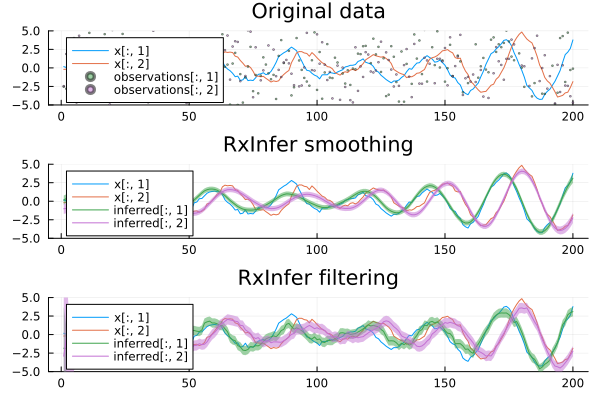

In [9]:
# Results verification

reshape_data(data) = transpose(reduce(hcat, data))

ylimit = (-5, 5)

generated_data = plot(1:n, real_x |> reshape_data, label = [ "x[:, 1]" "x[:, 2]" ])
generated_data = plot!(1:n, real_y |> reshape_data, seriestype = :scatter, ms = 1, alpha = 0.5, label = [ "observations[:, 1]" "observations[:, 2]" ])
generated_data = plot!(generated_data, legend = :bottomleft, ylimit = ylimit, title = "Original data")

rmp_smoothing_results_plot = plot(1:n, real_x |> reshape_data, label = [ "x[:, 1]" "x[:, 2]" ])
rmp_smoothing_results_plot = plot!(rmp_smoothing_results_plot, 1:n, mean.(x_reactivemp_smoothing_inferred) |> reshape_data, ribbon = var.(x_reactivemp_smoothing_inferred) |> reshape_data, label = [ "inferred[:, 1]" "inferred[:, 2]" ])
rmp_smoothing_results_plot = plot!(rmp_smoothing_results_plot, legend = :bottomleft, ylimit = ylimit, title = "RxInfer smoothing")

rmp_filtering_results_plot = plot(1:n, real_x |> reshape_data, label = [ "x[:, 1]" "x[:, 2]" ])
rmp_filtering_results_plot = plot!(rmp_filtering_results_plot, 1:n, mean.(x_reactivemp_filtering_inferred) |> reshape_data, ribbon = var.(x_reactivemp_filtering_inferred) |> reshape_data, label = [ "inferred[:, 1]" "inferred[:, 2]" ])
rmp_filtering_results_plot = plot!(rmp_filtering_results_plot, legend = :bottomleft, ylimit = ylimit, title = "RxInfer filtering")

p = plot(generated_data, rmp_smoothing_results_plot, rmp_filtering_results_plot, layout = @layout([ a; b; c ]))
    
savefig(p, "./plots/inference_rxinfer.png")
savefig(p, "./plots/inference_rxinfer.svg")

p

In [10]:
benchmark_rmp_sizes = [ 50, 100, 250, 500, 1_000, 2_000, 5_000, 10_000, 15_000, 20_000, 25_000, 50_000 ];

In [11]:
reactivemp_benchmark_results = map(benchmark_rmp_sizes) do size
    # states, observations = generate_data(size, A, B, P, Q);
    
    benchmark_smoothing = @benchmark reactivemp_inference_smoothing(observations, $A, $B, $P, $Q) seconds=30 setup=begin
        states, observations = generate_data($size, $A, $B, $P, $Q);
    end
    
    benchmark_fitlering = @benchmark reactivemp_inference_filtering(observations, $A, $B, $P, $Q) seconds=30 setup=begin
        states, observations = generate_data($size, $A, $B, $P, $Q);
    end
    
    println(stdout, "Finished $size")
    flush(stdout)
    
    return (size, benchmark_smoothing, benchmark_fitlering)
end

Finished 50
Finished 100
Finished 250
Finished 500
Finished 1000
Finished 2000
Finished 5000
Finished 10000
Finished 15000
Finished 20000
Finished 25000
Finished 50000


12-element Vector{Tuple{Int64, BenchmarkTools.Trial, BenchmarkTools.Trial}}:
 (50, 1.743 ms, 307.500 μs)
 (100, 3.492 ms, 558.375 μs)
 (250, 8.820 ms, 1.314 ms)
 (500, 18.242 ms, 2.573 ms)
 (1000, 38.756 ms, 5.094 ms)
 (2000, 82.356 ms, 10.156 ms)
 (5000, 224.877 ms, 25.615 ms)
 (10000, 452.278 ms, 51.420 ms)
 (15000, 693.894 ms, 78.320 ms)
 (20000, 933.334 ms, 103.350 ms)
 (25000, 1.157 s, 140.428 ms)
 (50000, 3.765 s, 289.479 ms)

In [12]:
benchmark_time_ms(trial) = mean(trial).time / 1_000_000

benchmark_time_ms (generic function with 1 method)

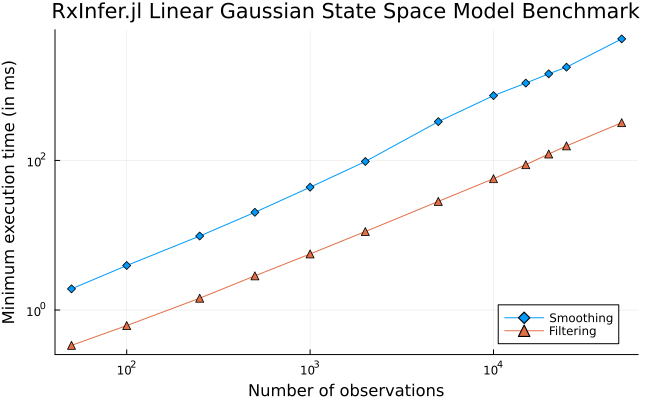

In [13]:
lgssm_scaling = plot(xscale = :log10, yscale = :log10, xlabel = "Number of observations", ylabel = "Minimum execution time (in ms)", title = "RxInfer.jl Linear Gaussian State Space Model Benchmark", legend = :bottomright, size = (650, 400))
lgssm_scaling = plot!(lgssm_scaling, benchmark_rmp_sizes, map(i -> benchmark_time_ms(reactivemp_benchmark_results[i][2]), 1:length(benchmark_rmp_sizes)), markershape = :diamond, label = "Smoothing")
lgssm_scaling = plot!(lgssm_scaling, benchmark_rmp_sizes, map(i -> benchmark_time_ms(reactivemp_benchmark_results[i][3]), 1:length(benchmark_rmp_sizes)), markershape = :utriangle, label = "Filtering")

display(lgssm_scaling)

# savefig(lgssm_scaling, "./plots/lgssm_scaling.svg")

In [30]:
import Turing, ReverseDiff, Memoization
# Turing.setbackend(:reversediff) see adtype = Turing.AutoReverseDiff(true)
# Turing.setrdcache(true)

In [15]:
Turing.@model LinearGaussianSSM(y, A, B, P, Q, ::Type{TV} = Vector{Vector{Float64}}) where TV = begin
    n = length(y)

    # State sequence.
    x = map(s -> zeros(2), 1:n)

    # Observe each point of the input.
    x[1] ~ MvNormal([ 0.0, 0.0 ], 1e1)
    y[1] ~ MvNormal(B * x[1], Q)

    for t in 2:n
        x[t] ~ MvNormal(A * x[t - 1], P)
        y[t] ~ MvNormal(B * x[t], Q)
    end
end;

In [35]:
function turing_inference_smoothing(observations, A, B, P, Q; nsamples = 500, method = Turing.HMC(0.05, 10; adtype = Turing.AutoReverseDiff(true)), seed = 42)
    return Turing.sample(StableRNG(seed), LinearGaussianSSM(observations, A, B, P, Q), method, nsamples)
end

turing_inference_smoothing (generic function with 1 method)

In [36]:
x_turing_500_smoothing_inferred  = turing_inference_smoothing(real_y, A, B, P, Q, nsamples = 500);
x_turing_1000_smoothing_inferred = turing_inference_smoothing(real_y, A, B, P, Q, nsamples = 1000);

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:02
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:05


In [37]:
samples_500  = get(x_turing_500_smoothing_inferred, :x);
samples_1000 = get(x_turing_1000_smoothing_inferred, :x);

mx_500 = [ mean(samples_500.x[i].data) for i in 1:2n ]
vx_500 = [ std(samples_500.x[i].data)  for i in 1:2n ];

mx_1000 = [ mean(samples_1000.x[i].data) for i in 1:2n ]
vx_1000 = [ std(samples_1000.x[i].data)  for i in 1:2n ];

In [38]:
reshape_turing_data(data) = transpose(reshape(data, (2, Int(length(data) / 2))))

reshape_turing_data (generic function with 1 method)

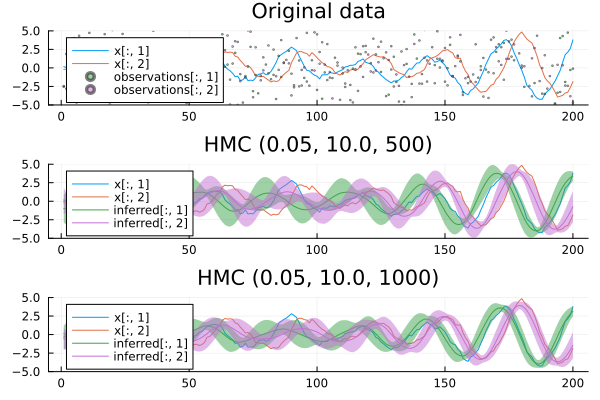

In [39]:
generated_data = plot(1:n, real_x |> reshape_data, label = [ "x[:, 1]" "x[:, 2]" ])
generated_data = plot!(1:n, real_y |> reshape_data, seriestype = :scatter, ms = 1, alpha = 0.5, label = [ "observations[:, 1]" "observations[:, 2]" ])
generated_data = plot!(generated_data, legend = :bottomleft, ylimit = ylimit, title = "Original data")

turing_500_results_plot = plot(1:n, real_x |> reshape_data, label = [ "x[:, 1]" "x[:, 2]" ])
turing_500_results_plot = plot!(turing_500_results_plot, 1:n, mx_500 |> reshape_turing_data, ribbon = vx_500 |> reshape_turing_data, label = [ "inferred[:, 1]" "inferred[:, 2]" ])
turing_500_results_plot = plot!(turing_500_results_plot, legend = :bottomleft, ylimit = ylimit, title = "HMC (0.05, 10.0, 500)")

turing_1000_results_plot = plot(1:n, real_x |> reshape_data, label = [ "x[:, 1]" "x[:, 2]" ])
turing_1000_results_plot = plot!(turing_1000_results_plot, 1:n, mx_1000 |> reshape_turing_data, ribbon = vx_1000 |> reshape_turing_data, label = [ "inferred[:, 1]" "inferred[:, 2]" ])
turing_1000_results_plot = plot!(turing_1000_results_plot, legend = :bottomleft, ylimit = ylimit, title = "HMC (0.05, 10.0, 1000)")

p = plot(generated_data, turing_500_results_plot, turing_1000_results_plot, layout = @layout([ a; b; c ]))
    
savefig(p, "./plots/inference_turing.png")
savefig(p, "./plots/inference_turing.svg")

p

# Benchmark 1000

In [40]:
real_x_1000, real_y_1000 = generate_data(1000, A, B, P, Q);

In [41]:
turing_500_n_1000_benchmark  = @benchmark turing_inference_smoothing($real_y_1000, $A, $B, $P, $Q, nsamples = 500);
turing_1000_n_1000_benchmark = @benchmark turing_inference_smoothing($real_y_1000, $A, $B, $P, $Q, nsamples = 1000);

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:15
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:16
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:15
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:15
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:30
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:30
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:30
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:29


In [23]:
reactivemp_filtering_n_1000_benchmark = @benchmark reactivemp_inference_filtering($real_y_1000, $A, $B, $P, $Q);
reactivemp_smoothing_n_1000_benchmark = @benchmark reactivemp_inference_smoothing($real_y_1000, $A, $B, $P, $Q);

In [52]:
using ColorSchemes, Colors ;


c = palette(:rainbow)

c1 = get(ColorSchemes.rainbow, 0.5) ; 
c2 = get(ColorSchemes.rainbow, 0.9) ; 
c3 = get(ColorSchemes.rainbow, 0.3) ; 
c4 = get(ColorSchemes.rainbow, 0.8) ; 
c5 = get(ColorSchemes.rainbow, 0.9) ;

colors = [ c1, c2, c3, c4 ];

In [25]:
import CairoMakie

[ Info: Precompiling CairoMakie [13f3f980-e62b-5c42-98c6-ff1f3baf88f0]
[ Info: Precompiling GeometryBasicsExt [b238bd29-021f-5edc-8b0e-16b9cda5f63a]
[ Info: Precompiling FileIOExt [f5f51d8f-5827-5d2e-939b-192fcd6ec70c]


┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/Qvk4f/src/scenes.jl:220


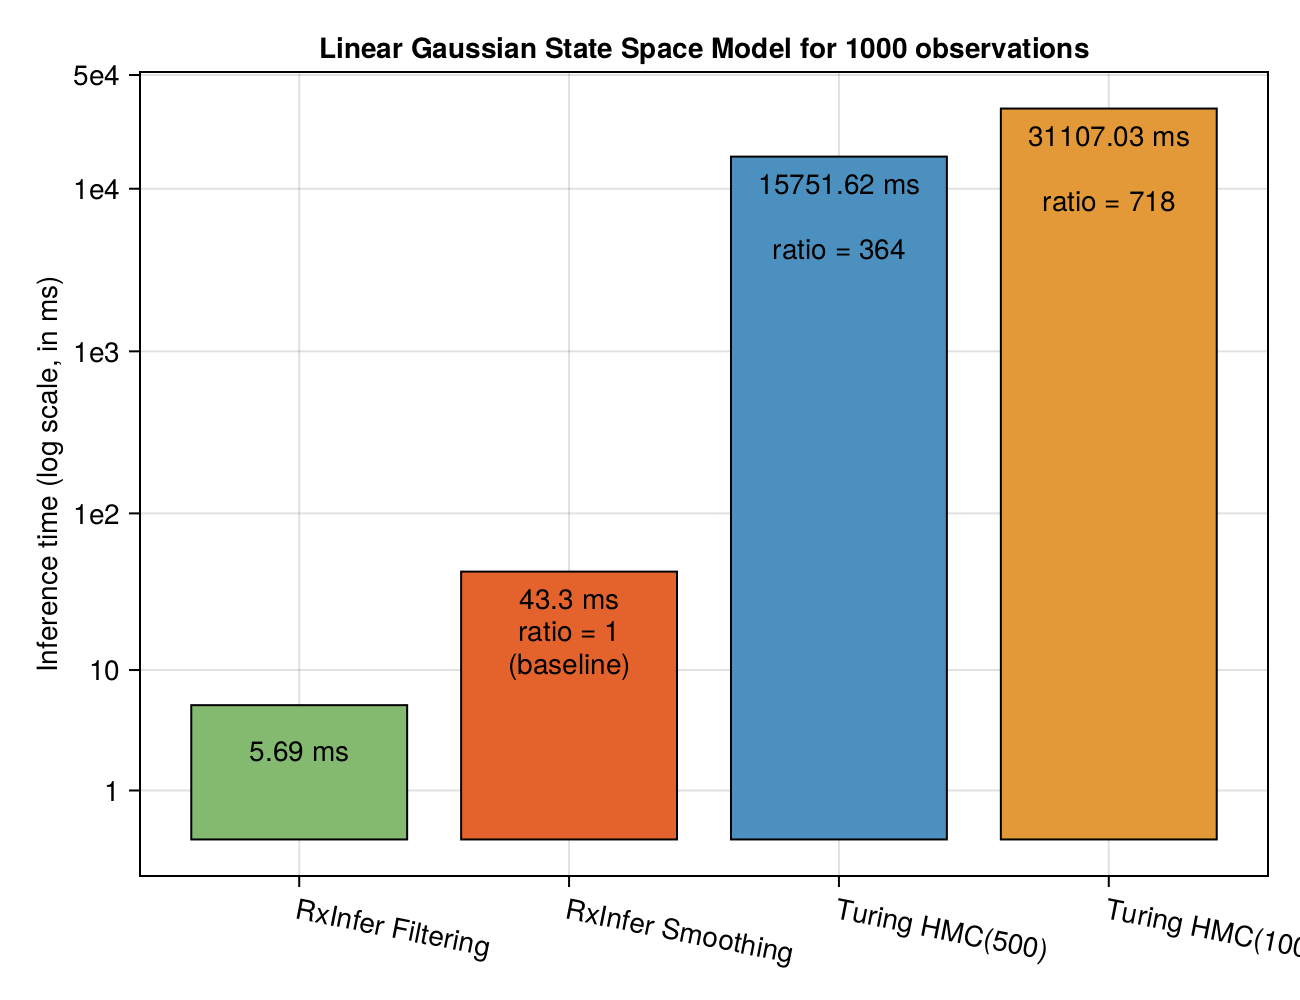

In [53]:
comparison_fig = begin
    
    # Local vars
    local bar_names  = [ "RxInfer Filtering", "RxInfer Smoothing", "Turing HMC(500)", "Turing HMC(1000)" ]
    local bar_values = [
        benchmark_time_ms(reactivemp_filtering_n_1000_benchmark),
        benchmark_time_ms(reactivemp_smoothing_n_1000_benchmark),
        benchmark_time_ms(turing_500_n_1000_benchmark),
        benchmark_time_ms(turing_1000_n_1000_benchmark)
    ] 
    
    
    local range = 1:length(bar_names)
    
    
    # Figure
    
    local fig = CairoMakie.Figure(resolution = (650, 500), backgroundcolor = :transparent)

    # Axis
    
    local ax  = CairoMakie.Axis(fig, backgroundcolor = :transparent)
    ax.ylabel = "Inference time (log scale, in ms)"
    ax.title  = "Linear Gaussian State Space Model for 1000 observations"
    ax.yscale = CairoMakie.Makie.pseudolog10
    ax.yticks = ([ 1, 10, 100, 1000, 10_000, 50_000 ], [ "1", "10", "1e2", "1e3", "1e4", "5e4" ])
    ax.xticklabelrotation = -π / 16
    # ax.xticklabelalign = (0.5, 1.5)
    
    ax.xticks = (range, bar_names)
    ax.xticklabelsize = 14
    
    # Barplot 1
    
    local bp = CairoMakie.barplot!(ax, range, bar_values, color = colors)
    
    bp.strokewidth = 1
    # bp.color    = colors
    bp.colormap = (:Accent_4, 0.9)
    bp.strokecolor = :black
    bp.x_gap = 0.12
    
    
    local text_values = map(bar_values) do value
        return string(round(value, digits = 2), " ms")
    end
    
    text_values[2] = string(text_values[2], "\n", string("ratio = ", Int(round(bar_values[2] / bar_values[2])), "\n(baseline)"))
    text_values[3] = string(text_values[3], "\n\n", string("ratio = ", Int(round(bar_values[3] / bar_values[2])), ""))
    text_values[4] = string(text_values[4], "\n\n", string("ratio = ", Int(round(bar_values[4] / bar_values[2])), ""))
    
    local tx = CairoMakie.text!(text_values, position = CairoMakie.Point.(range, bar_values .+ [ 1.55, 0.25, 0, 0 ]))
    
    tx.align  = (:center, :center)
    tx.offset = (0, -30)
    # tx.color  = [ :black, :black, :black, :black ]
    tx.textsize = 13
    
    # Layout

    fig[1, 1] = ax
    
    # Return 
    
    CairoMakie.save("./plots/lgssm_comparison.svg", fig)
    CairoMakie.save("./plots/lgssm_comparison.png", fig)
    
    fig
end

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/Qvk4f/src/scenes.jl:220


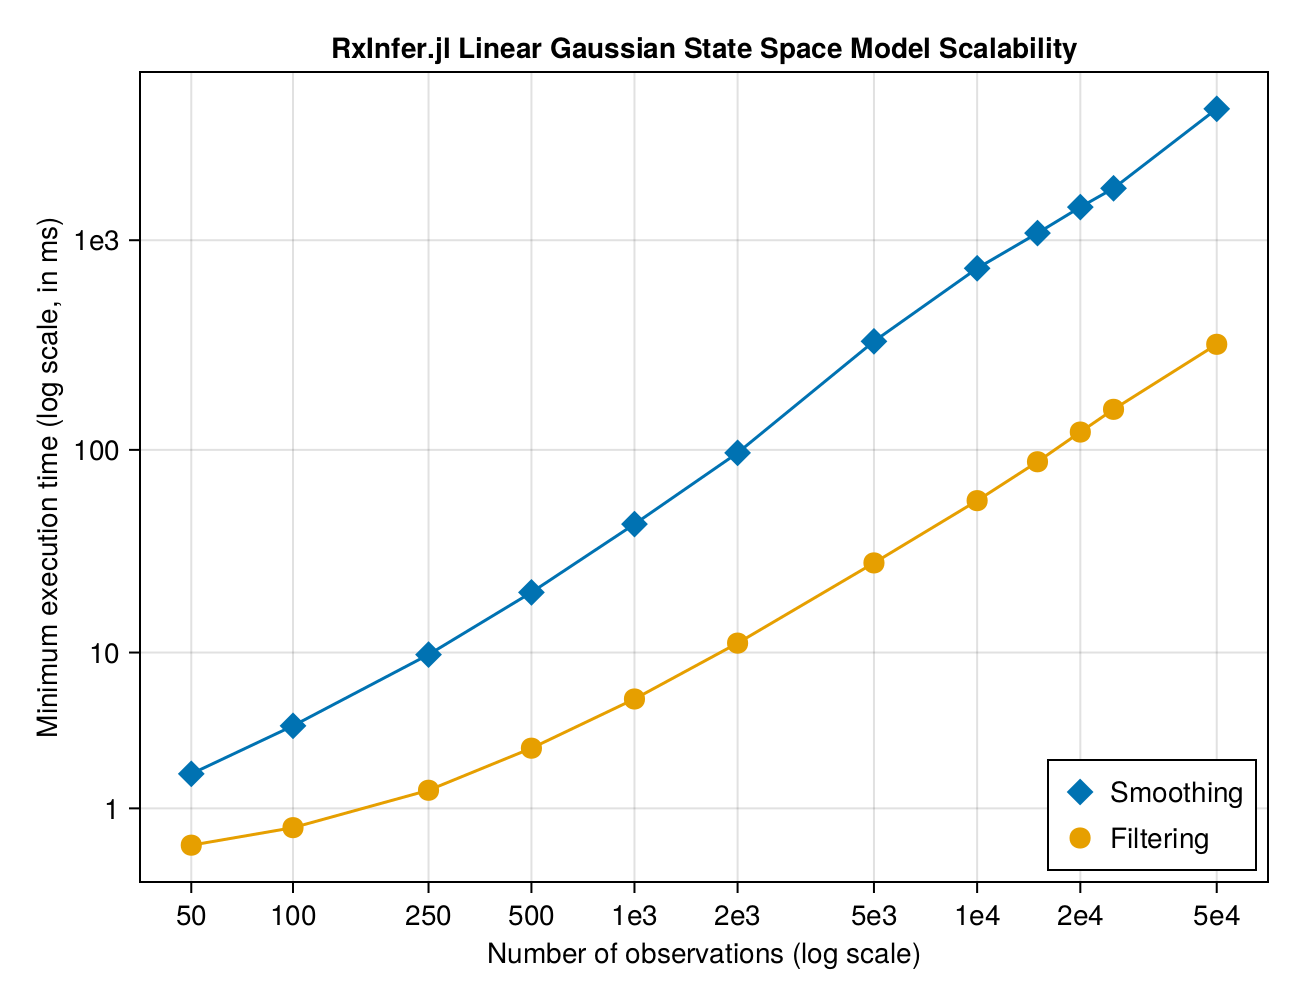

In [46]:
scaling_fig = begin 
    local fig = CairoMakie.Figure(resolution = (650, 500), backgroundcolor = :transparent)
    
    local ax = CairoMakie.Axis(fig[1, 1], backgroundcolor = :transparent)
    
    ax.title = "RxInfer.jl Linear Gaussian State Space Model Scalability"
    
    ax.xlabel = "Number of observations (log scale)"
    ax.xscale = CairoMakie.Makie.pseudolog10
    ax.xticks = (
        [ 50, 100, 250, 500, 1_000, 2_000, 5_000, 10_000, 20_000, 50_000 ], 
        [ "50", "100", "250", "500", "1e3", "2e3", "5e3", "1e4", "2e4", "5e4" ]
    )
    
    ax.ylabel = "Minimum execution time (log scale, in ms)"
    ax.yscale = CairoMakie.Makie.pseudolog10
    ax.yticks = (
        [ 1, 10, 100, 1_000, 10_000, 50_000 ], 
        [ "1", "10", "100", "1e3", "1e4", "5e4" ]
    )
    
    local range = benchmark_rmp_sizes
    local smoothing = map(i -> benchmark_time_ms(reactivemp_benchmark_results[i][2]), 1:length(benchmark_rmp_sizes))
    local filtering = map(i -> benchmark_time_ms(reactivemp_benchmark_results[i][3]), 1:length(benchmark_rmp_sizes))
    
    CairoMakie.lines!(ax, range, smoothing)
    CairoMakie.scatter!(ax, range, smoothing, marker = :diamond, markersize = 15, label = "Smoothing")
    
    CairoMakie.lines!(ax, range, filtering)
    CairoMakie.scatter!(ax, range, filtering, marker = :circle, markersize = 15, label = "Filtering")
    
    CairoMakie.axislegend(position = :rb)
    
    CairoMakie.save("./plots/lgssm_scaling.svg", fig)
    CairoMakie.save("./plots/lgssm_scaling.png", fig)
    
    fig
end